In [8]:
%load_ext autoreload
%autoreload 2
import jax
from jax import random
from envs.rodent import RodentTracking
from envs.humanoid import HumanoidTracking
from envs.ant import AntTracking

from brax.training.agents.ppo import networks as ppo_networks

import numpy as np
import mediapy as media
import jax.numpy as jp
import mujoco

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
trained_standing_params = "model_checkpoints/c54f32c8-13b5-484b-9849-84953ac80487/finished_mlp"


#### Ant env

In [19]:
params = {
    "solver": "newton",
    "iterations": 1,
    "ls_iterations": 4,
    "clip_path": "ant_traj_still.p",
}

In [20]:
ant = AntTracking(params)

In [20]:
ant.sys.nbody

10

In [21]:
state = ant.reset(jax.random.PRNGKey(0))

In [22]:
frames = ant.render([state.pipeline_state])
media.show_video(frames, fps=1.0 / ant.dt)

In [24]:
from mujoco import mjx
from brax.io import mjcf as mjcf_brax
from brax.io import model
from brax import envs
from brax.training.acme import running_statistics
from envs.humanoid import HumanoidStanding
import networks as ppo_networks
env_params = {
    "solver": "cg",
    "iterations": 6,
    "ls_iterations": 6,
    "clip_path": "humanoid_traj.p",
}    
eval_env = HumanoidStanding(env_params)

env_state = eval_env.reset(jax.random.PRNGKey(0))
normalize = running_statistics.normalize
ppo_network = ppo_networks.make_ppo_networks(
    env_state.obs.shape[-1],
    eval_env.action_size,
    preprocess_observations_fn=normalize,
    policy_hidden_layer_sizes=(512,) * 3,
    value_hidden_layer_sizes=(512,) * 4,
    layer_norm=True)

make_policy = ppo_networks.make_inference_fn(ppo_network)

params = model.load_params("policies/humanoidstanding_finished")
inference_fn = make_policy(params)
jit_inference_fn = jax.jit(inference_fn)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [30]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 250
for i in range(n_steps + 5):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    print(f"done at {i}")
    
media.show_video(eval_env.render(rollout, camera='side'), fps=1.0 / eval_env.dt)

In [34]:
qposes = [data.qpos for data in rollout]
qvels = [data.qvel for data in rollout]
xposes = [data.xpos for data in rollout]
coms = [data.subtree_com[1] for data in rollout]
xquats = [data.xquat for data in rollout]

qposes = np.stack(qposes)
qvels = np.stack(qvels)
xposes = np.stack(xposes)
coms = np.stack(coms)
xquats = np.stack(xquats)

mocap_features = {}
mocap_features["position"] = qposes[:,:3]
mocap_features["quaternion"] = qposes[:,3:7]
mocap_features["joints"] = qposes[:, 7:]
mocap_features["center_of_mass"] = np.reshape(coms, (coms.shape[0], -1))
mocap_features["end_effectors"] = []
mocap_features["velocity"] = qvels[:, :3]
mocap_features["angular_velocity"] = qvels[:, 3:6]
mocap_features["joints_velocity"] = qvels[:, 6:]
mocap_features["appendages"] = []
mocap_features["body_positions"] = xposes
mocap_features["body_quaternions"] = xquats # np.reshape(xquats, (xquats.shape[0], -1))

mocap_features['markers'] = None
mocap_features['scaling'] = None


In [37]:
mocap_features["body_positions"].shape

(256, 17, 3)

In [36]:
from mocap_preprocess import save_dataclass_pickle
save_dataclass_pickle("humanoid_traj_stand.p", mocap_features)

'humanoid_traj_stand.p'

In [112]:
import mocap_preprocess as mp
data_path = "../stac-mjx/transform_snips.p"
clip_paths = mp.process(data_path, 
         "transform_snips_250.h5", 
         n_steps=250,
         start_step=500,
         ref_steps=(1,2,3,4,5))

start_step: 500
(250, 3)


In [15]:
# making static trajectory for ant
qpos = data.qpos
qvel = data.qvel
xpos = data.xpos
com = data.subtree_com[1]
xquat = data.xquat

qposes = np.tile(qpos, (250, 1))
qvels = np.tile(qvel, (250, 1))
xposes = np.tile(xpos, (250, 1, 1))
coms = np.tile(com, (250, 1))
xquats = np.tile(xquat, (250, 1, 1))

mocap_features = {}
mocap_features["position"] = qposes[:,:3]
mocap_features["quaternion"] = qposes[:,3:7]
mocap_features["joints"] = qposes[:, 7:]
mocap_features["center_of_mass"] = np.reshape(coms, (coms.shape[0], -1))
mocap_features["end_effectors"] = []
mocap_features["velocity"] = qvels[:, :3]
mocap_features["angular_velocity"] = qvels[:, 3:6]
mocap_features["joints_velocity"] = qvels[:, 6:]
mocap_features["appendages"] = []
mocap_features["body_positions"] = xposes
mocap_features["body_quaternions"] = xquats # np.reshape(xquats, (xquats.shape[0], -1))

In [16]:
mocap_features['body_positions'].shape


(250, 10, 3)

In [17]:
from mocap_preprocess import ReferenceClip, save_dataclass_pickle

mocap_features['markers'] = None
mocap_features['scaling'] = None
save_dataclass_pickle("ant_traj_still.p", mocap_features)

'ant_traj_still.p'

#### Humanoid env

In [25]:
params = {
    "solver": "cg",
    "iterations": 6,
    "ls_iterations": 6,
    "clip_path": "humanoid_traj.p",
}

In [26]:
humanoid = HumanoidTracking(params)

In [27]:
humanoid.sys.nbody

17

In [37]:
obj_id = mujoco.mj_name2id(humanoid.sys.mj_model, mujoco.mju_str2Type("body"), "head")
obj_id

2

In [38]:
state = humanoid.reset(jax.random.PRNGKey(0))

In [42]:
state.pipeline_state.xpos[2]

Array([-5.4630125e-04,  7.6789209e-03,  1.4727731e+00], dtype=float32)

In [26]:
state.obs.shape

(457,)

In [21]:
state.pipeline_state.qpos.shape[0] + \
state.pipeline_state.qvel.shape[0] + \
state.pipeline_state.qfrc_actuator.shape[0]

82

In [6]:
key = random.PRNGKey(0)
humanoid_step = jax.jit(humanoid.step)
humanoid_reset = jax.jit(humanoid.reset)

In [7]:
next = humanoid_reset(key)
print("starting rollout")
mu = 0
sigma = .1
rollout = []
for _ in range(250):
    _, key = jax.random.split(key)
    next = humanoid_step(next, mu + sigma * random.normal(key, shape=(humanoid.sys.nu,)))
    rollout.append(next)

starting rollout


In [8]:
import mediapy as media
import os

os.environ["MUJOCO_GL"] = "glfw"
rollout_data = [s.pipeline_state for s in rollout]

video = humanoid.render(rollout_data, camera='side', height=500, width=500)

media.show_video(video, fps=1.0 / humanoid.dt)

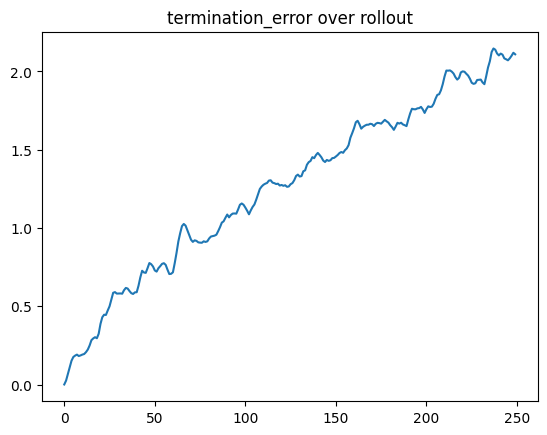

In [9]:
from matplotlib import pyplot as plt
# plot termination error over time:
errors = [s.metrics['termination_error'] for s in rollout]
plt.title("termination_error over rollout")
plt.plot(errors)

#### Rodent env

In [29]:
params = {
    "scale_factor": .9,
    "solver": "cg",
    "iterations": 6,
    "ls_iterations": 6,
    "xml_path": "assets/rodent.xml",
    "clip_path": "transform_snips_250_clip_750.p",
    "walker_body_names": ['torso', 'pelvis', 'upper_leg_L', 'lower_leg_L', 'foot_L', 'upper_leg_R', 'lower_leg_R', 'foot_R', 'skull', 'jaw', 'scapula_L', 'upper_arm_L', 'lower_arm_L', 'finger_L', 'scapula_R', 'upper_arm_R', 'lower_arm_R', 'finger_R'],
    "end_eff_names": [
        "foot_L",
        "foot_R",
        "hand_L",
        "hand_R",
    ],
}

# Creating env objects

In [30]:
env = RodentTracking(params)

In [31]:
for n in range(100):
      print(mujoco.mj_id2name(env.sys.mj_model, 
                          mujoco.mju_str2Type("joint"), 
                          n))

root
vertebra_1_extend
vertebra_2_bend
vertebra_3_twist
vertebra_4_extend
vertebra_5_bend
vertebra_6_twist
hip_L_supinate
hip_L_abduct
hip_L_extend
knee_L
ankle_L
toe_L
hip_R_supinate
hip_R_abduct
hip_R_extend
knee_R
ankle_R
toe_R
vertebra_C1_extend
vertebra_C1_bend
vertebra_C2_extend
vertebra_C2_bend
vertebra_C3_extend
vertebra_C3_bend
vertebra_C4_extend
vertebra_C4_bend
vertebra_C5_extend
vertebra_C5_bend
vertebra_C6_extend
vertebra_C6_bend
vertebra_C7_extend
vertebra_C9_bend
vertebra_C11_extend
vertebra_C13_bend
vertebra_C15_extend
vertebra_C17_bend
vertebra_C19_extend
vertebra_C21_bend
vertebra_C23_extend
vertebra_C25_bend
vertebra_C27_extend
vertebra_C29_bend
vertebra_cervical_5_extend
vertebra_cervical_4_bend
vertebra_cervical_3_twist
vertebra_cervical_2_extend
vertebra_cervical_1_bend
vertebra_axis_twist
vertebra_atlant_extend
atlas
mandible
scapula_L_supinate
scapula_L_abduct
scapula_L_extend
shoulder_L
shoulder_sup_L
elbow_L
wrist_L
finger_L
scapula_R_supinate
scapula_R_abduct

In [58]:
key = random.PRNGKey(0)
jit_step = jax.jit(env.step)
jit_reset = jax.jit(env.reset)
# next = env.step(state, random.uniform(key, shape=(env.sys.nu,)))

In [59]:
key, subkey = jax.random.split(key) 
state = env.reset(subkey)
env._calculate_termination(state)

[-4.7722409e-04  2.8163995e-04 -8.4090367e-04  6.0226081e-04
  1.0404602e-03  1.6914152e-03  1.0947160e-03 -1.0179050e-04
  1.6476601e-04 -2.8294667e-03  8.8693126e-04 -5.1368203e-04
  5.9041288e-04 -8.8200113e-04  1.2494448e-03  2.5188155e-04
  9.9422257e-05 -1.2817878e-03 -6.5700745e-04  4.4882563e-05
 -5.1222701e-04  5.1518338e-04 -6.2167970e-04 -1.9824257e-04
 -9.5051968e-05  1.1424529e-03 -3.0697577e-04  4.8699298e-05
  3.5624456e-04  5.6182063e-04  1.5389369e-03  3.2522317e-04
  1.3367548e-03  9.8856224e-04  1.4204493e-03  5.4973963e-04
 -1.5584289e-04 -8.5814483e-04  2.5936909e-04 -1.1357025e-03
 -8.4086983e-05 -4.0105707e-04  1.7144010e-04  1.3368111e-03
  1.0823595e-04 -3.1889335e-04  1.1413924e-04 -1.6834441e-04
 -2.3103834e-03  1.6328682e-04  1.0740045e-03  1.1257745e-03
 -1.2201234e-03  1.2311945e-03  5.8456970e-04 -1.0888724e-03
 -6.0622208e-04  1.0449032e-03 -1.3182943e-03 -1.8421815e-03
  2.5926733e-03  4.1853130e-04  6.2172447e-04 -1.9652639e-03
 -4.5445902e-04  1.37276

Array(0.88605523, dtype=float32)

Array(-0.5230558, dtype=float32)

In [76]:
env._ref_traj.body_positions.shape

(250, 18, 3)

In [77]:
next = jit_reset(key)
print("starting rollout")
mu = 0
sigma = .3
rollout = []
for _ in range(250):
    _, key = random.split(key)
    next = jit_step(next, mu + sigma * random.normal(key, shape=(env.sys.nu,)))
    rollout.append(next)

starting rollout


In [78]:
import mediapy as media
import os

os.environ["MUJOCO_GL"] = "glfw"
rollout_data = [s.pipeline_state for s in rollout]

video = env.render(rollout_data, camera='side_alt', height=512, width=512)
media.show_video(video, fps=50)

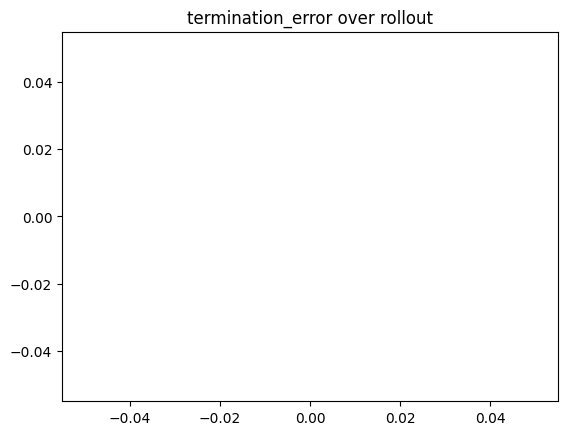

In [14]:
from matplotlib import pyplot as plt
# plot termination error over time:
errors = [s.metrics['termination_error'] for s in rollout]
plt.title("termination_error over rollout")
plt.plot(errors)

In [ ]:
jax.tree_util.tree_map(
    lambda x: print(x.shape),
    env._ref_traj,
)